In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import io
import cv2
import copy
import os
from tqdm import tqdm
import torch.nn as nn
import torch
import torchvision
from torch.utils.data import Dataset
from torch import default_generator, randperm
from torch._utils import _accumulate
from torch.utils.data.dataset import Subset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
batch_size = 16
momentum=0.9
lr = 1e-3
import random
sub_sample = 0.5
import matplotlib
import gc
import torchsig.utils as u
import torchsig.transforms.transforms as T
matplotlib.use('Agg')

cuda:0


In [2]:
s = T.Spectrogram(nperseg=1024)

In [3]:
def sig2pic_with_spec(path_to_data, filename, specT=None, figsize=(16,16), dpi=64):
    try:
        if specT is None:
            specT = T.Spectrogram(nperseg=1024)
        with open(path_to_data + filename, 'rb') as file:
            tmp = np.frombuffer(file.read(), dtype=np.complex64)
        signal = tmp
        spectr = np.array(specT(signal)[:,:figsize[0] * dpi])
        fig1 = plt.figure(figsize = figsize)
        plt.axes(ylim=(-1, 1))
        sigr = signal.real
        sigi = signal.imag
        
        plt.plot(sigr, color='black')
        plt.gca().set_axis_off()
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        buf1 = io.BytesIO()
        fig1.savefig(buf1, format="png", dpi=dpi)
        buf1.seek(0)
        img_arr1 = np.frombuffer(buf1.getvalue(), dtype=np.uint8)
        buf1.close()
        img1 = cv2.imdecode(img_arr1, 1)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        plt.close()

        fig2 = plt.figure(figsize = figsize)
        plt.axes(ylim=(-1, 1))
        sigr = signal.real
        sigi = signal.imag
        
        plt.plot(sigi, color='black')
        plt.gca().set_axis_off()
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        buf = io.BytesIO()
        fig2.savefig(buf, format="png", dpi=dpi)
        buf.seek(0)
        img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
        buf.close()
        img = cv2.imdecode(img_arr, 1)
        img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        plt.close()
        # print(img1.shape)
        # print(img2.shape)
        # print(spectr.shape)
        img = np.array([img1, img2, spectr])
        return img
    except Exception as e:
        print(str(e))
        return None

In [6]:
path_to_binaries = 'calib/'
path_to_pictures = 'calib_spectr/'

In [7]:
bin_subdirs = os.listdir(path_to_binaries)

In [8]:
from tqdm import tqdm

In [10]:
for subdir in bin_subdirs:
    filepath = path_to_binaries + subdir + '/'
    if not os.path.exists(path_to_pictures + subdir):
        os.mkdir(path_to_pictures + subdir)
    files = os.listdir(filepath)
    for file in tqdm(files):
        if not file.endswith('.npy'):
            continue
        savepath = path_to_pictures + subdir + '/' + file + '.npy'
        if not os.path.exists(savepath):
            img = sig2pic_with_spec(path_to_data=filepath, filename=file, specT=s)
            #print(img.shape)
            np.save(savepath, img)
            #print('File: ', file, ', shape: ', img.shape , ' saved to ', savepath)
            gc.collect()
        else:
            print('file ',  file, ' already exists!')
    print('Dir: ', subdir , ' finished!')

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: 'calib_spectr/.ipynb_checkpoints'

In [3]:
def sig2pic_save(path_to_data, filename, figsize, dpi, path_to_save = 's'):
    try:
        with open(path_to_data + filename, 'rb') as file:
            tmp = np.frombuffer(file.read(), dtype=np.complex64)
        signal = tmp
        sigr = signal.real
        sigi = signal.imag
            
        with plt.figure(figsize=figsize) as fig1:
            plt.axes(ylim=(-1, 1))

            plt.plot(sigr, color='black')
            plt.gca().set_axis_off()
            plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
            plt.margins(0, 0)
            
            if not os.path.exists(path_to_save + filename.split('/')[0]):
                os.makedirs(path_to_save + filename.split('/')[0])
            fig1.savefig(path_to_save + filename + '.png', pad_inches=0, dpi=dpi)
            print('fig1 saved')

        del fig1
        del signal
        del tmp
        return None
    except Exception as e:
        print(str(e))
        return None

In [10]:
def get_data(path_to_data, filename):
    try:
        with open(path_to_data + filename, 'rb') as file:
            signal = np.frombuffer(file.read(), dtype=np.complex64)
            sigr = signal.real
            sigi = signal.imag
            signal = [sigr, sigi]
            return signal
            
    except Exception as e:
        print(str(e))
        return None

In [27]:
def sig2pic_save1(path_to_data, filename, signal, figsize, dpi, path_to_save = 's'):       
        fig1 = plt.figure(figsize=figsize)
        plt.axes(ylim=(-1, 1))

        plt.plot(signal[0], color='black')
        plt.gca().set_axis_off()
        # plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
        # plt.margins(0, 0)
        
        if not os.path.exists(path_to_save + filename.split('/')[0]):
            os.makedirs(path_to_save + filename.split('/')[0])
        fig1.savefig(path_to_save + filename + '.png', pad_inches=0, dpi=dpi)
        plt.close('all')
        print('fig1 saved&closed')
        return None


In [28]:
root_path = 'S:/drone_dataset_v4.0/'
csv_path = 'S:/drone_dataset_v4.0/dataset.csv'
path_to_save = 'drone_dataset_v4.0_pictures/'
fig_size = (24,8)
dpi=50

In [29]:
df = pd.read_csv(csv_path)

fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved&closed
fig1 saved

MemoryError: Unable to allocate 15.3 MiB for an array with shape (1000000, 2) and data type float64

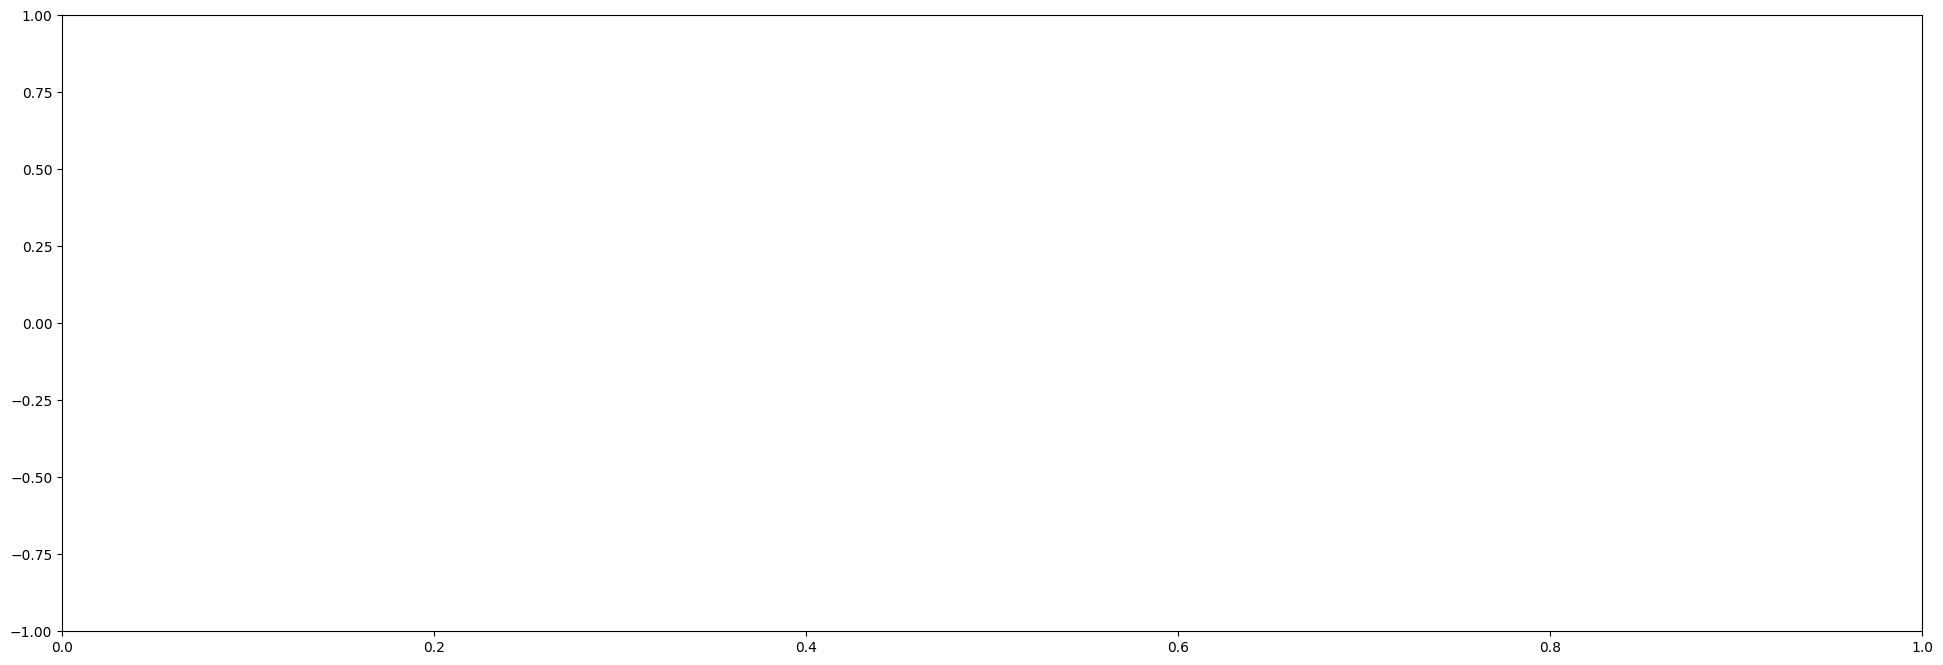

In [30]:
for i in range(len(df['fragment_name'])):
    signal = get_data(root_path, df['fragment_name'][i])
    if signal is not None:
        sig2pic_save1(root_path, df['fragment_name'][i], signal, fig_size, dpi, path_to_save)

In [11]:
img.shape

(2, 400, 1200)

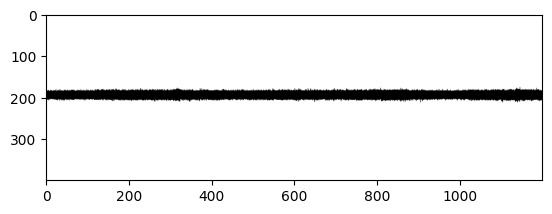

In [12]:
fig, ax = plt.subplots()
ax.imshow(img[0], cmap='gray')


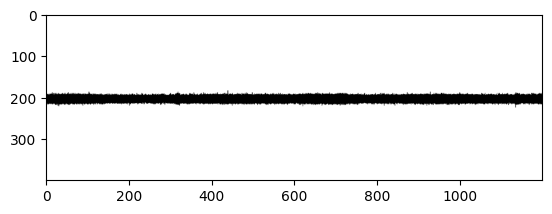

In [13]:
fig, ax = plt.subplots()
ax.imshow(img[1], cmap='gray')

In [14]:
np.sum(img[0] - img[1])

3355111